<a href="https://colab.research.google.com/github/yasohasakii/binary_categorical/blob/master/resnet_binary_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# git clone repository
!git clone https://github.com/yasohasakii/binary_categorical.git
!mv ./binary_categorical/* ./
!rm -r ./binary_categorical ./sample_data
!pip install tensorflow-gpu
!nvidia-smi

Cloning into 'binary_categorical'...
remote: Enumerating objects: 22660, done.
remote: Counting objects: 100% (22660/22660), done.
remote: Compressing objects: 100% (22650/22650), done.
remote: Total 22660 (delta 19), reused 22642 (delta 10), pack-reused 0
Receiving objects: 100% (22660/22660), 957.02 MiB | 35.23 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (22662/22662), done.
     |████████████████████████████████| 377.0MB 103kB/s 


Wed Aug 28 10:32:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
# import modual
import os, glob, time
import numpy as np
from keras.layers import Input
from keras.models import Model
from keras.preprocessing import image
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications.resnet50 import ResNet50
os.environ['CUDA_VISIBLE_DEVICES']='0'

Using TensorFlow backend.


In [0]:
# assert parameters
FC_NUMS = 8
batch_size = 50
EPOCHS=10

train_count = len(glob.glob('./PetImages/train/*/*.jpg'))
valid_count = len(glob.glob('./PetImages/test/*/*.jpg'))

In [0]:
# def build_model
def build_model(istrain):
    input = Input(shape = (256,256,3),name="kfb_image")
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input) 
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_NUMS, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    if istrain:
        x = Dropout(0.2)(x)
    prediction = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=prediction)

    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

In [0]:
# def train
def train(train_count,valid_count,istrain=False):
    train_datagen = image.ImageDataGenerator(
        rescale = 1./255, 
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)
    valid_datagen = image.ImageDataGenerator(
        rescale = 1./255)

    train_generator = train_datagen.flow_from_directory(
        './PetImages/train/',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary')
    validation_generator = valid_datagen.flow_from_directory(
        './PetImages/test',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary')

    model = build_model(istrain)
    models_save_path = "./models"
    if not os.path.exists(models_save_path):
        os.makedirs(models_save_path)

    checkpoint = ModelCheckpoint(filepath=os.path.join(models_save_path, 'resnet-{epoch:02d}-{val_acc:.4f}.h5'),
                                 monitor='val_acc',
                                 mode='max',
                                 save_best_only=True,
                                 save_weights_only=True)
    print("Train files: {}, valid files: {}".format(train_count,valid_count))
    print('-----------Start training-----------')
    start = time.time()
    history = model.fit_generator(train_generator,
                        steps_per_epoch=train_count // batch_size,
                        epochs=EPOCHS,
                        initial_epoch=0,
                        validation_data=validation_generator,
                        validation_steps=valid_count // batch_size,
                        callbacks=[checkpoint],
                        use_multiprocessing=False)
    end = time.time()
    print("train finished, cost time = {} hours".format(round((end - start) / 3600.0,3)))
    return history

In [0]:
# def plot modual
def plot_train_history(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig("history.png")

In [0]:
# def test
def test(model_path,image_dir):
    model = build_model(False)
    model.load_weights(model_path, by_name=True)
    images = glob.glob(image_dir+"/*.jpg")
    preds=0
    for imgs in images:
        im = image.load_img(imgs, target_size=(256, 256))
        im = image.img_to_array(im)* 1. / 255
        im = np.expand_dims(im, axis=0)
        out = model.predict(im)
        print(np.argmax(out,axis=1))
        preds += out
    if preds/len(images)>0.5:
        print("{}: cat".format(os.path.basename(image_dir)))
    else:
        print("{}: dog".format(os.path.basename(image_dir)))

In [7]:
if __name__=="__main__":
    history = train(train_count,valid_count,istrain=True)

Found 15894 images belonging to 2 classes.


W0828 10:35:46.762248 139751606593408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 10:35:46.784404 139751606593408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0828 10:35:46.814648 139751606593408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 10:35:46.815748 139751606593408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0828 10:35:46.81658

Found 6754 images belonging to 2 classes.


W0828 10:35:48.766968 139751606593408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0828 10:35:48.860312 139751606593408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


W0828 10:36:00.912224 139751606593408 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0828 10:36:00.953698 139751606593408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 10:36:00.983250 139751606593408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train files: 15894, valid files: 6754
-----------Start training-----------
Epoch 1/10
 20/317 [>.............................] - ETA: 13:32 - loss: 0.5336 - acc: 0.7990

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

 47/317 [===>..........................] - ETA: 9:12 - loss: 0.5691 - acc: 0.7685

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


142/317 [============>.................] - ETA: 4:58 - loss: 0.4772 - acc: 0.7942

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


247/317 [======================>.......] - ETA: 1:54 - loss: 0.4183 - acc: 0.8174

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expect

283/317 [=========================>....] - ETA: 55s - loss: 0.4044 - acc: 0.8242

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

304/317 [===========================>..] - ETA: 21s - loss: 0.3938 - acc: 0.8293

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

317/317 [==============================] - 581s 2s/step - loss: 0.3891 - acc: 0.8318 - val_loss: 0.8209 - val_acc: 0.6130
Epoch 2/10
317/317 [==============================] - 559s 2s/step - loss: 0.2220 - acc: 0.9124 - val_loss: 0.3976 - val_acc: 0.8678
Epoch 3/10
317/317 [==============================] - 556s 2s/step - loss: 0.1796 - acc: 0.9307 - val_loss: 0.3342 - val_acc: 0.9035
Epoch 4/10
317/317 [==============================] - 556s 2s/step - loss: 0.1656 - acc: 0.9399 - val_loss: 0.2717 - val_acc: 0.9206
Epoch 5/10
317/317 [==============================] - 556s 2s/step - loss: 0.1465 - acc: 0.9458 - val_loss: 0.6806 - val_acc: 0.6599
Epoch 6/10
317/317 [==============================] - 555s 2s/step - loss: 0.1390 - acc: 0.9473 - val_loss: 0.2151 - val_acc: 0.9180
Epoch 7/10
317/317 [==============================] - 556s 2s/step - loss: 0.1338 - acc: 0.9500 - val_loss: 0.2241 - val_acc: 0.9154
Epoch 8/10
317/317 [==============================] - 558s 2s/step - loss: 0.125

NameError: ignored

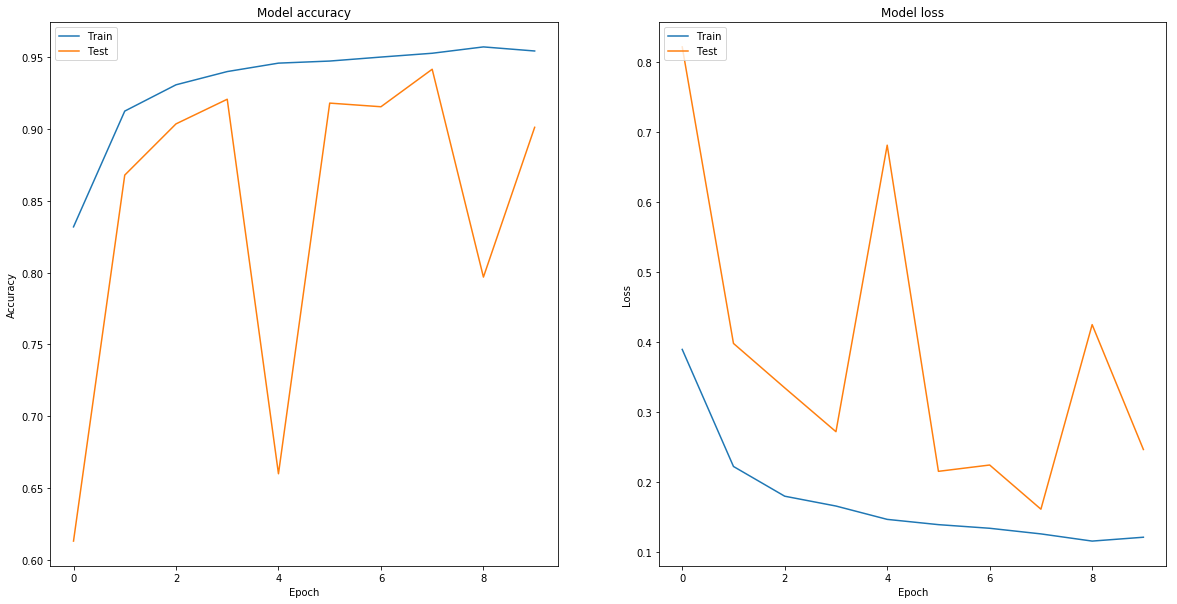

In [8]:
plot_train_history(history)

In [0]:
test('./models/resnet-08-0.9415.h5','./PetImages/test/Cat')
    

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
